# Signal denoising

This notebook accompanies the paper [Learning Convex Optimization Models](https://web.stanford.edu/~boyd/papers/learning_copt_models.html).

In [22]:
import math

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from cvxpylayers.torch import CvxpyLayer

# import latexify
# latexify.latexify()

torch.set_default_tensor_type(torch.DoubleTensor)
%matplotlib inline

In [23]:
torch.random.manual_seed(0)
np.random.seed(0)
N_train = 500
N_val = 100
n = 100
m = 100
n_regions = 100
n_points_per_region = n // n_regions
Sigma_sqrt = 0.1*np.random.randn(n, n)
Sigma = Sigma_sqrt.T @ Sigma_sqrt
normal = torch.distributions.MultivariateNormal(loc=torch.zeros(n), covariance_matrix=torch.tensor(Sigma))

inputs = []
outputs = []
eval_pts = torch.linspace(0, 2*math.pi, n)
for i in range(N_train + N_val):
    b = np.random.uniform(low=1, high=3)
    y = torch.cos(b*eval_pts)
    x = y.clone()
    x += normal.sample()
    inputs.append(x)
    outputs.append(y)

inputs = torch.stack(inputs)
outputs = torch.stack(outputs)

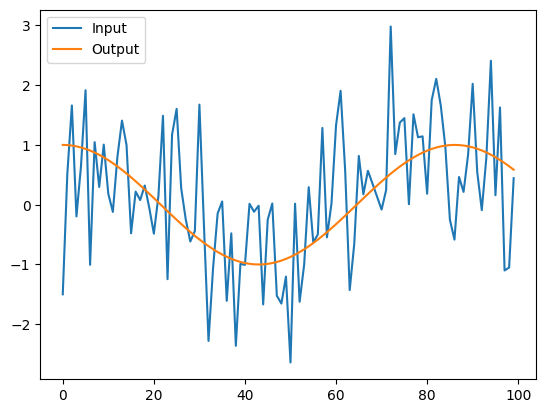

In [43]:
idx = np.random.randint(low=0, high=N_train+N_val)
plt.plot(inputs[idx], label="Input")
plt.plot(outputs[idx], label="Output")
plt.legend()

In [25]:
X_train = inputs[:N_train]
Y_train = outputs[:N_train]

X_val = inputs[N_train:]
Y_val = outputs[N_train:]

In [26]:
def create_layer():
    y_cp = cp.Variable(n)
    x_minus_y = cp.Variable(n)
    
    x_param = cp.Parameter(n)
    theta_param = cp.Parameter((n, n))
    lambda_param = cp.Parameter(pos=True)
    objective = (
        cp.sum_squares(theta_param @ x_minus_y) +
        lambda_param*cp.sum_squares(cp.diff(y_cp))
    )
    constraints = [
        x_minus_y == x_param - y_cp
    ]
    problem = cp.Problem(cp.Minimize(objective), constraints)
    layer = CvxpyLayer(
        problem,
        parameters=[x_param, theta_param, lambda_param],
        variables=[y_cp])
    return layer
    

layer = create_layer()

In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from cvxpylayers.torch import CvxpyLayer

torch.set_default_dtype(torch.double)

from tqdm import tqdm


def fit(loss, params, X, Y, Xval, Yval, batch_size=128, lr=1e-3, epochs=100, verbose=False, print_every=1, callback=None):
    """

    Arguments:
        loss: given x and y in batched form, evaluates loss.
        params: list of parameters to optimize.
        X: input data, torch tensor.
        Y: output data, torch tensor.
        Xval: input validation data, torch tensor.
        Yval: output validation data, torch tensor.
    """

    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(params, lr=lr)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        if callback is not None:
            callback()
            
        with torch.no_grad():
            val_losses.append(loss(Xval, Yval).item())
        if verbose and epoch % print_every == 0:
            print("val loss %03d | %3.5f" % (epoch + 1, val_losses[-1]))

        batch = 1
        train_losses.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if verbose and epoch % print_every == 0:
                print("batch %03d / %03d | %3.5f" %
                      (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
    return val_losses, train_losses

In [28]:
theta_tch = torch.eye(n, requires_grad=True)
lambda_tch = torch.tensor(0.5, requires_grad=True)
params = [theta_tch, lambda_tch]

def loss_fn(X, actual):
    preds = layer(X, theta_tch, lambda_tch)[0]
    mse_per_example = (preds - actual).pow(2).mean(axis=1)
    return mse_per_example.mean()

In [29]:
val_losses, train_losses =  fit(
    loss_fn, params, X_train, Y_train, X_val, Y_val, lr=1e-2, batch_size=64,
    epochs=50, verbose=True, print_every=5)

  0%|          | 0/50 [00:00<?, ?it/s]

val loss 001 | 0.38664
batch 001 / 008 | 0.39937
batch 002 / 008 | 0.36861
batch 003 / 008 | 0.35514
batch 004 / 008 | 0.33468
batch 005 / 008 | 0.31791
batch 006 / 008 | 0.30365
batch 007 / 008 | 0.29135


  2%|▏         | 1/50 [00:10<08:41, 10.64s/it]

batch 008 / 008 | 0.27934


 10%|█         | 5/50 [00:56<08:26, 11.26s/it]

val loss 006 | 0.07108
batch 001 / 008 | 0.05291
batch 002 / 008 | 0.05233
batch 003 / 008 | 0.05279
batch 004 / 008 | 0.05283
batch 005 / 008 | 0.05227
batch 006 / 008 | 0.05265
batch 007 / 008 | 0.05284


 12%|█▏        | 6/50 [01:08<08:25, 11.48s/it]

batch 008 / 008 | 0.05311


 20%|██        | 10/50 [01:58<08:07, 12.20s/it]

val loss 011 | 0.04574
batch 001 / 008 | 0.02893
batch 002 / 008 | 0.03103
batch 003 / 008 | 0.03165
batch 004 / 008 | 0.03267
batch 005 / 008 | 0.03293
batch 006 / 008 | 0.03326
batch 007 / 008 | 0.03340


 22%|██▏       | 11/50 [02:11<08:05, 12.46s/it]

batch 008 / 008 | 0.03383


 30%|███       | 15/50 [03:04<07:29, 12.85s/it]

val loss 016 | 0.03507
batch 001 / 008 | 0.02534
batch 002 / 008 | 0.02542
batch 003 / 008 | 0.02546
batch 004 / 008 | 0.02634
batch 005 / 008 | 0.02598
batch 006 / 008 | 0.02578
batch 007 / 008 | 0.02620


 32%|███▏      | 16/50 [03:16<07:08, 12.60s/it]

batch 008 / 008 | 0.02592


 40%|████      | 20/50 [04:08<06:27, 12.93s/it]

val loss 021 | 0.02723
batch 001 / 008 | 0.01848
batch 002 / 008 | 0.01917
batch 003 / 008 | 0.02039
batch 004 / 008 | 0.02028
batch 005 / 008 | 0.02068
batch 006 / 008 | 0.02112
batch 007 / 008 | 0.02123


 42%|████▏     | 21/50 [04:20<06:09, 12.74s/it]

batch 008 / 008 | 0.02135


 50%|█████     | 25/50 [05:09<05:04, 12.19s/it]

val loss 026 | 0.02441
batch 001 / 008 | 0.01531
batch 002 / 008 | 0.01559
batch 003 / 008 | 0.01647
batch 004 / 008 | 0.01714
batch 005 / 008 | 0.01751
batch 006 / 008 | 0.01794
batch 007 / 008 | 0.01812


 52%|█████▏    | 26/50 [05:20<04:48, 12.03s/it]

batch 008 / 008 | 0.01845


 60%|██████    | 30/50 [06:11<04:08, 12.43s/it]

val loss 031 | 0.02099
batch 001 / 008 | 0.01645
batch 002 / 008 | 0.01648
batch 003 / 008 | 0.01673
batch 004 / 008 | 0.01658
batch 005 / 008 | 0.01658
batch 006 / 008 | 0.01666
batch 007 / 008 | 0.01675


 62%|██████▏   | 31/50 [06:23<03:54, 12.32s/it]

batch 008 / 008 | 0.01678


 70%|███████   | 35/50 [07:10<03:00, 12.05s/it]

val loss 036 | 0.01853
batch 001 / 008 | 0.01154
batch 002 / 008 | 0.01314
batch 003 / 008 | 0.01368
batch 004 / 008 | 0.01418
batch 005 / 008 | 0.01439
batch 006 / 008 | 0.01439
batch 007 / 008 | 0.01462


 72%|███████▏  | 36/50 [07:22<02:48, 12.03s/it]

batch 008 / 008 | 0.01470


 80%|████████  | 40/50 [08:16<02:10, 13.02s/it]

val loss 041 | 0.01745
batch 001 / 008 | 0.01216
batch 002 / 008 | 0.01244
batch 003 / 008 | 0.01322
batch 004 / 008 | 0.01357
batch 005 / 008 | 0.01361
batch 006 / 008 | 0.01363
batch 007 / 008 | 0.01369


 82%|████████▏ | 41/50 [08:28<01:54, 12.74s/it]

batch 008 / 008 | 0.01365


 90%|█████████ | 45/50 [09:18<01:03, 12.78s/it]

val loss 046 | 0.01643
batch 001 / 008 | 0.01241
batch 002 / 008 | 0.01264
batch 003 / 008 | 0.01268
batch 004 / 008 | 0.01294
batch 005 / 008 | 0.01298
batch 006 / 008 | 0.01291
batch 007 / 008 | 0.01298


 92%|█████████▏| 46/50 [09:31<00:50, 12.67s/it]

batch 008 / 008 | 0.01316


100%|██████████| 50/50 [10:21<00:00, 12.42s/it]


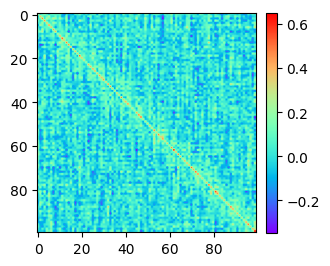

In [30]:
plt.figure(figsize=(3.4, 3.4))
plt.imshow(theta_tch.detach().numpy(), cmap='rainbow')
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

In [31]:
lambda_tch

tensor(1.0835, requires_grad=True)

In [32]:
with torch.no_grad():
    val_preds = layer(X_val, theta_tch, lambda_tch)[0]

In [33]:
with torch.no_grad():
    train_preds = layer(X_train, theta_tch, lambda_tch)[0]

In [34]:
y_cp = cp.Variable(n)
x_minus_y = cp.Variable(n)

x_param = cp.Parameter(n)
lambda_param = cp.Parameter(pos=True)

objective = (
    cp.sum_squares(x_param - y_cp) +
    lambda_param*cp.sum_squares(cp.diff(y_cp))
)
problem = cp.Problem(cp.Minimize(objective))
one_param_layer = CvxpyLayer(problem=problem, parameters=[x_param, lambda_param], variables=[y_cp])

In [35]:
lambda_values = torch.linspace(0, 20, 10)
best_lambda = None
lowest_loss = np.inf
for value in tqdm(lambda_values):
    print('lambda ', value)
    preds = one_param_layer(X_train, value, 
        solver_args = {
            "acceleration_lookback": 0,
            "max_iters": 10000
        })[0]
    mse_per_example = (preds - Y_train).pow(2).mean(axis=1)
    mse = mse_per_example.mean()
    print('mse', mse)
    if mse < lowest_loss:
        print('lowest mse yet')
        lowest_loss = mse
        best_lambda = value

  0%|          | 0/10 [00:00<?, ?it/s]

lambda  tensor(0.)


 10%|█         | 1/10 [00:01<00:14,  1.60s/it]

mse tensor(0.9800)
lowest mse yet
lambda  tensor(2.2222)


 20%|██        | 2/10 [00:03<00:12,  1.56s/it]

mse tensor(0.1777)
lowest mse yet
lambda  tensor(4.4444)


 30%|███       | 3/10 [00:04<00:11,  1.60s/it]

mse tensor(0.1263)
lowest mse yet
lambda  tensor(6.6667)


 40%|████      | 4/10 [00:06<00:09,  1.62s/it]

mse tensor(0.1066)
lowest mse yet
lambda  tensor(8.8889)


 50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

mse tensor(0.0971)
lowest mse yet
lambda  tensor(11.1111)


 60%|██████    | 6/10 [00:09<00:06,  1.64s/it]

mse tensor(0.0924)
lowest mse yet
lambda  tensor(13.3333)


 70%|███████   | 7/10 [00:11<00:04,  1.65s/it]

mse tensor(0.0904)
lowest mse yet
lambda  tensor(15.5556)


 80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

mse tensor(0.0901)
lowest mse yet
lambda  tensor(17.7778)


 90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

mse tensor(0.0910)
lambda  tensor(20.)


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

mse tensor(0.0926)


In [36]:
print(best_lambda)

tensor(15.5556)


In [37]:
print(lowest_loss)

tensor(0.0901)


In [38]:
one_param_preds = one_param_layer(X_val, best_lambda, 
        solver_args = {
            "acceleration_lookback": 0,
            "max_iters": 10000
        })[0]
mse_per_example = (one_param_preds - Y_val).pow(2).mean(axis=1)
one_param_mse = mse_per_example.mean()
print(one_param_mse)

tensor(0.0897)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


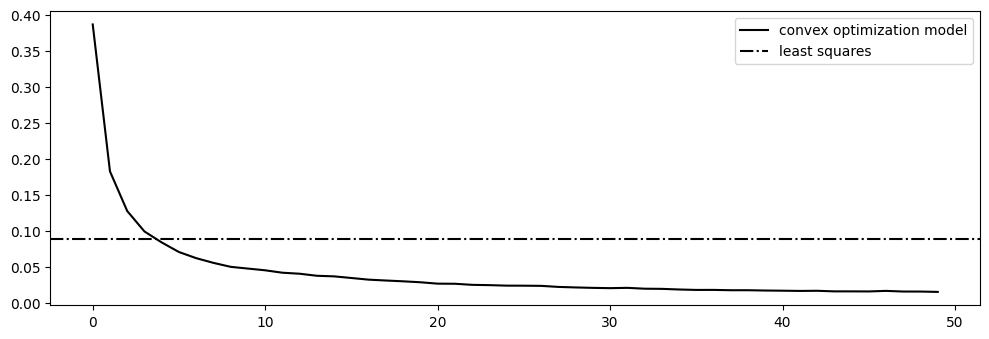

In [39]:
%load_ext autoreload
%autoreload 2
# import latexify
# latexify.latexify()

plt.figure(figsize=(10., 3.5))
ax = plt.gca()
plt.plot(val_losses[:100], color='k', label='convex optimization model')
ax.axhline(one_param_mse, color='k', linestyle='-.', label='least squares')
plt.legend()
plt.tight_layout()

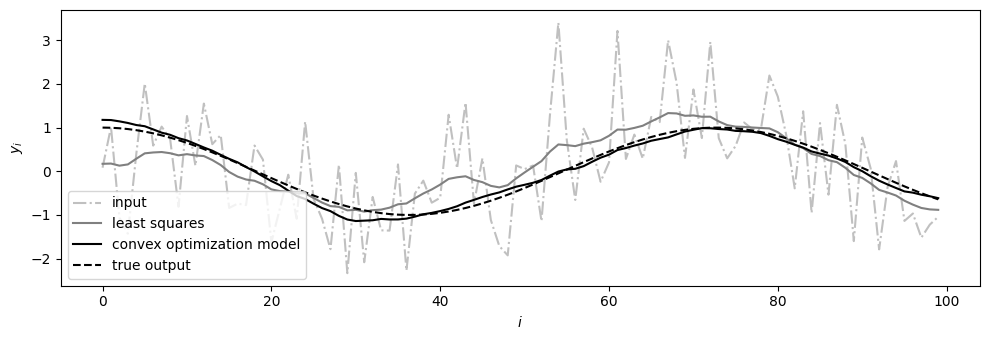

In [40]:
idx = 1
plt.figure(figsize=(10., 3.5))
plt.plot(X_val[idx], label='input', color='silver', linestyle='-.')
plt.plot(one_param_preds[idx], label='least squares', color='gray', linestyle='-',)
plt.plot(val_preds[idx], label='convex optimization model', color='k', linestyle='-')
plt.plot(Y_val[idx], label='true output', linestyle='--', color='k')
plt.xlabel('$i$')
plt.ylabel('$y_i$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()